# Analysing the Best Model

In [5]:
# Imports
import matplotlib.pyplot as plt
import heapq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from math import floor, ceil, inf

from edinburgh_challenge.constants import police_stations, police_stations_dict
from edinburgh_challenge.utility import generate_early_shift_distributions
from edinburgh_challenge.models import NaiveModel, GreedyModel
from edinburgh_challenge.simulation import *
from edinburgh_challenge.processing import calculate_metric, calculate_simulation_performance

In [6]:
source = "./data.xlsx"
data = pd.read_excel(source)
data["Time"] = (data["Day"]-1)*24 + data["Hour"]
data.columns = [x.lower() for x in data.columns]

In [7]:
# Running the best model
shift_distribution = {'Early': {'Station_1': 0, 'Station_2': 5, 'Station_3': 10},
  'Day': {'Station_1': 2, 'Station_2': 19, 'Station_3': 4},
  'Night': {'Station_1': 9, 'Station_2': 3, 'Station_3': 28}
}

ps_coords = [ (p.x, p.y) for p in 
                [police_stations.one, 
                 police_stations.two, 
                 police_stations.three]]

simulation = SimulationWithMaxUtilisation(data, ps_coords, shift_distribution, 
                        verbose=0)



greedy_model = GreedyModel(shift_distribution, police_stations_dict)

In [8]:
simulation.run(greedy_model)
print(f"Performance: {calculate_simulation_performance(simulation.analyze_simulation_results())}")

Performance: 0.9973702067085207


## Resource Allocation Graph

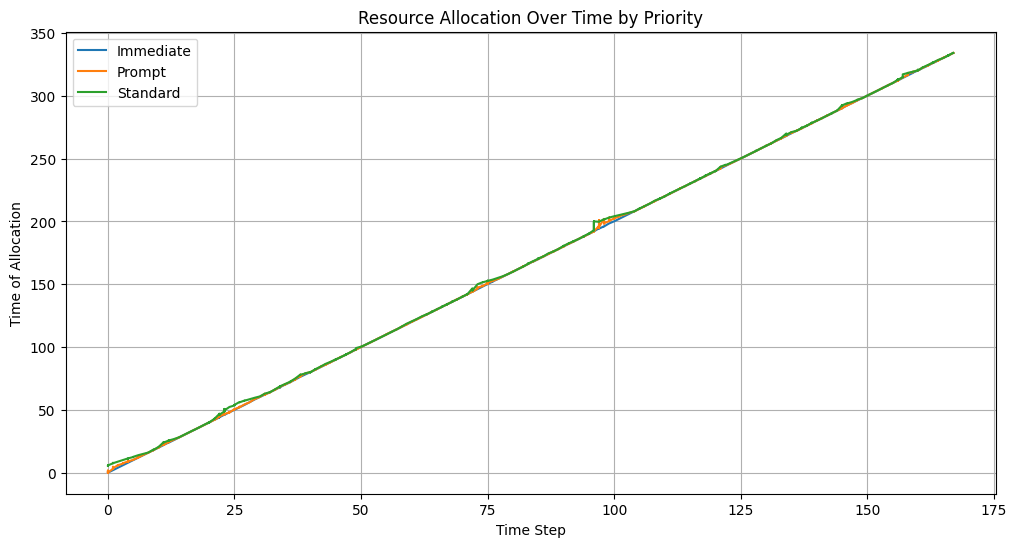

In [16]:
priority_allocations = {'Immediate': [], 'Prompt': [], 'Standard': []}

# Iterate through cumulative incidents and gather data by priority
for incident in simulation.cumulative_incidents:
    priority = incident.priority
    resolution_time = incident.resolution_time
    time_of_allocation = incident.global_time + incident.response_time
    
    # Append data to the corresponding priority list
    priority_allocations[priority].append((incident.global_time, resolution_time, time_of_allocation))

# Create separate resource allocation graphs for each priority
plt.figure(figsize=(12, 6))

for priority, data in priority_allocations.items():
    if data:
        data.sort(key=lambda x: x[0])  # Sort data by time_step
        time_steps, resolution_times, allocation_times = zip(*data)
        plt.plot(time_steps, allocation_times, label=priority)

# Customize the plot
plt.title('Resource Allocation Over Time by Priority')
plt.xlabel('Time Step')
plt.ylabel('Time of Allocation')
plt.legend()
plt.grid(True)
plt.show()

## Model's Geographic Plots

### Geospatial time taken to allocate cases

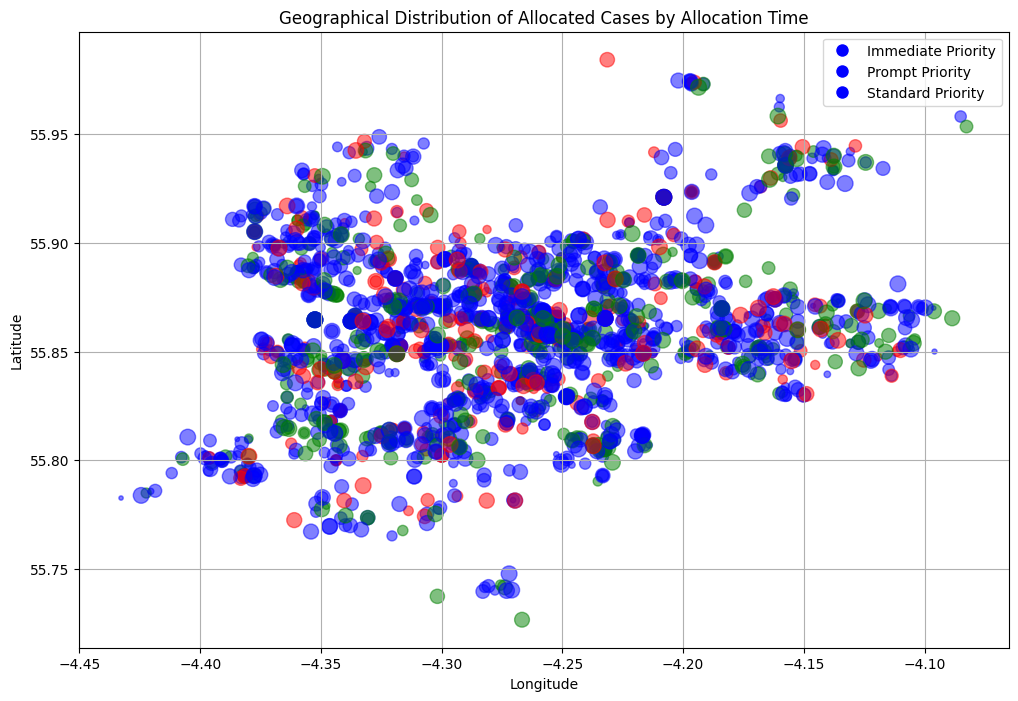

In [33]:
# Extract incident data
allocated_incidents = [incident for incident in simulation.cumulative_incidents if incident.resolved]
lats = [incident.latitude for incident in allocated_incidents]
lons = [incident.longitude for incident in allocated_incidents]
allocation_times = np.array([(incident.response_time - incident.global_time) for incident in allocated_incidents])*1.5
priorities = [incident.priority for incident in allocated_incidents]

# Define a color mapping for priorities (red for Immediate, blue for Prompt, green for Standard)
color_mapping = {'Immediate': 'red', 'Prompt': 'blue', 'Standard': 'green'}
colors = [color_mapping[priority] for priority in priorities]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(lons, lats, s=np.sqrt(resolutions) * 10, alpha=0.5, c=colors, label='Allocated Cases')

# Customize the plot
plt.title('Geographical Distribution of Allocated Cases by Allocation Time')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend
legend_labels = ['Immediate Priority', 'Prompt Priority', 'Standard Priority']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[priority], markersize=10) for priority in priorities]
plt.legend(legend_handles, legend_labels, loc='best')

plt.grid(True)
plt.show()


### Geospatial resolution time 

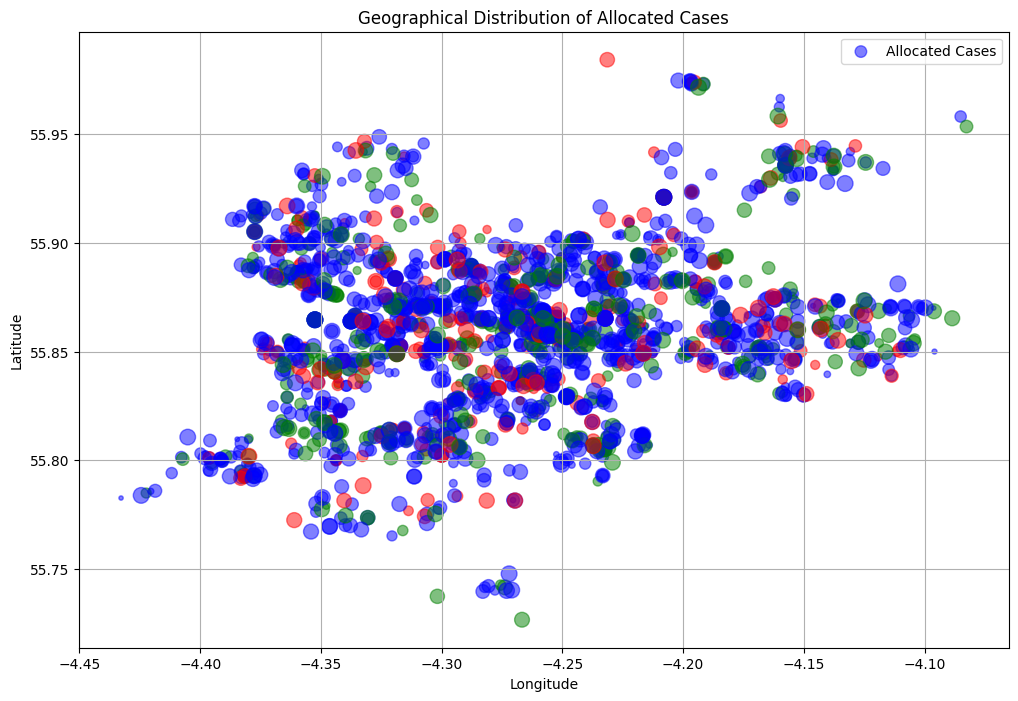

In [26]:
# Extract incident data
allocated_incidents = [incident for incident in simulation.cumulative_incidents if incident.resolved]
lats = [incident.latitude for incident in allocated_incidents]
lons = [incident.longitude for incident in allocated_incidents]
resolutions = [incident.resolution_time for incident in allocated_incidents]
priorities = [incident.priority for incident in allocated_incidents]

# Define color mapping for priorities
color_mapping = {'Immediate': 'red', 'Prompt': 'blue', 'Standard': 'green'}
colors = [color_mapping[priority] for priority in priorities]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(lons, lats, s=np.sqrt(resolutions) * 10, alpha=0.5, c=colors, label='Allocated Cases')

# Customize the plot
plt.title('Geographical Distribution of Allocated Cases')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
incident

Incident(urn='PS-20220715-3304', latitude=55.811316, longitude=-4.2169313, day=7, hour=23, global_time=167, deployment_time=1.55, priority='Prompt', distances={'Station_1': 4.270434532417634, 'Station_2': 2.613773418622155, 'Station_3': 1.7432437668497345}, resolved=True, resolving_officer='Officer_Station_3_Night_19', response_time=167.05810812556166, resolution_time=168.60810812556167)

## Bar Plots

### Time taken to allocate

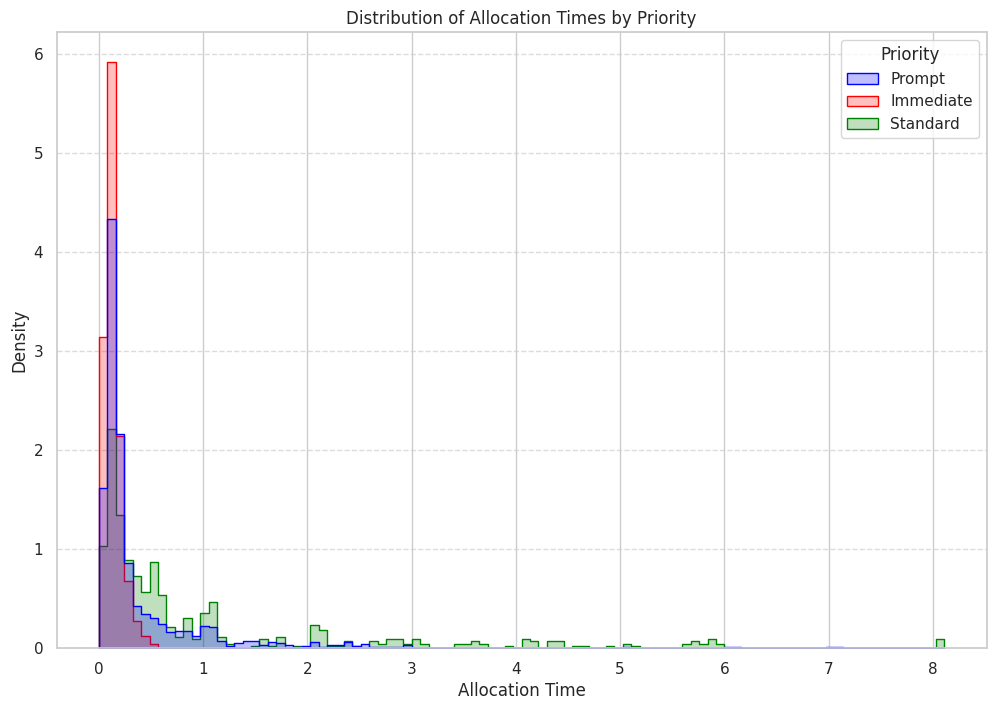

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract incident data
allocated_incidents = [incident for incident in simulation.cumulative_incidents if incident.resolved]
allocation_times = [(incident.response_time - incident.global_time) for incident in allocated_incidents]
priorities = [incident.priority for incident in allocated_incidents]

# Create a DataFrame for the data
import pandas as pd
data = pd.DataFrame({'Allocation Time': allocation_times, 'Priority': priorities})

# Set Seaborn style
sns.set(style="whitegrid")

# Create a color palette for priorities
palette = {"Immediate": "red", "Prompt": "Blue", "Standard": "Green"}

# Create the distribution plot with fewer bins
plt.figure(figsize=(12, 8))
sns.histplot(data=data, x="Allocation Time", hue="Priority", kde=False, palette=palette, common_norm=False,
             bins=100, element="step", stat="density")

# Customize the plot
plt.xlabel('Allocation Time')
plt.ylabel('Density')
plt.title('Distribution of Allocation Times by Priority')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
